# NAWEA WOMBAT Interactive Example

NOTE: This workshop is based on the v0.9 release of WOMBAT, and as of October 26th, this is the current version in the develop branch.

First, import the necessary packages and make adjust some of the Pandas display settings.

In [1]:
from time import perf_counter
from pathlib import Path

import pandas as pd

from wombat import Simulation
from wombat.utilities import plot

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

## Set up and demonstration of `Simulation`

First, we create a variable for our library directory, relative to this notebook, and have `Path` resolve it to ensure it exists. Then, we'll create a simulation for both an in situ and tow-to-port simulation (pre-configured in `library/corewind/project/config/`).

Note that a random seed is being set at the simulation level so that the same results get produced every single time these are run.

In [2]:
library_path = Path("../library/corewind/").resolve()

sim_in_situ = Simulation(library_path=library_path, config="morro_bay_in_situ.yaml", random_seed=34)
sim_ttp = Simulation(library_path=library_path, config="morro_bay_tow_to_port.yaml", random_seed=34)

### View the farm to verify it's what we saw in the slides

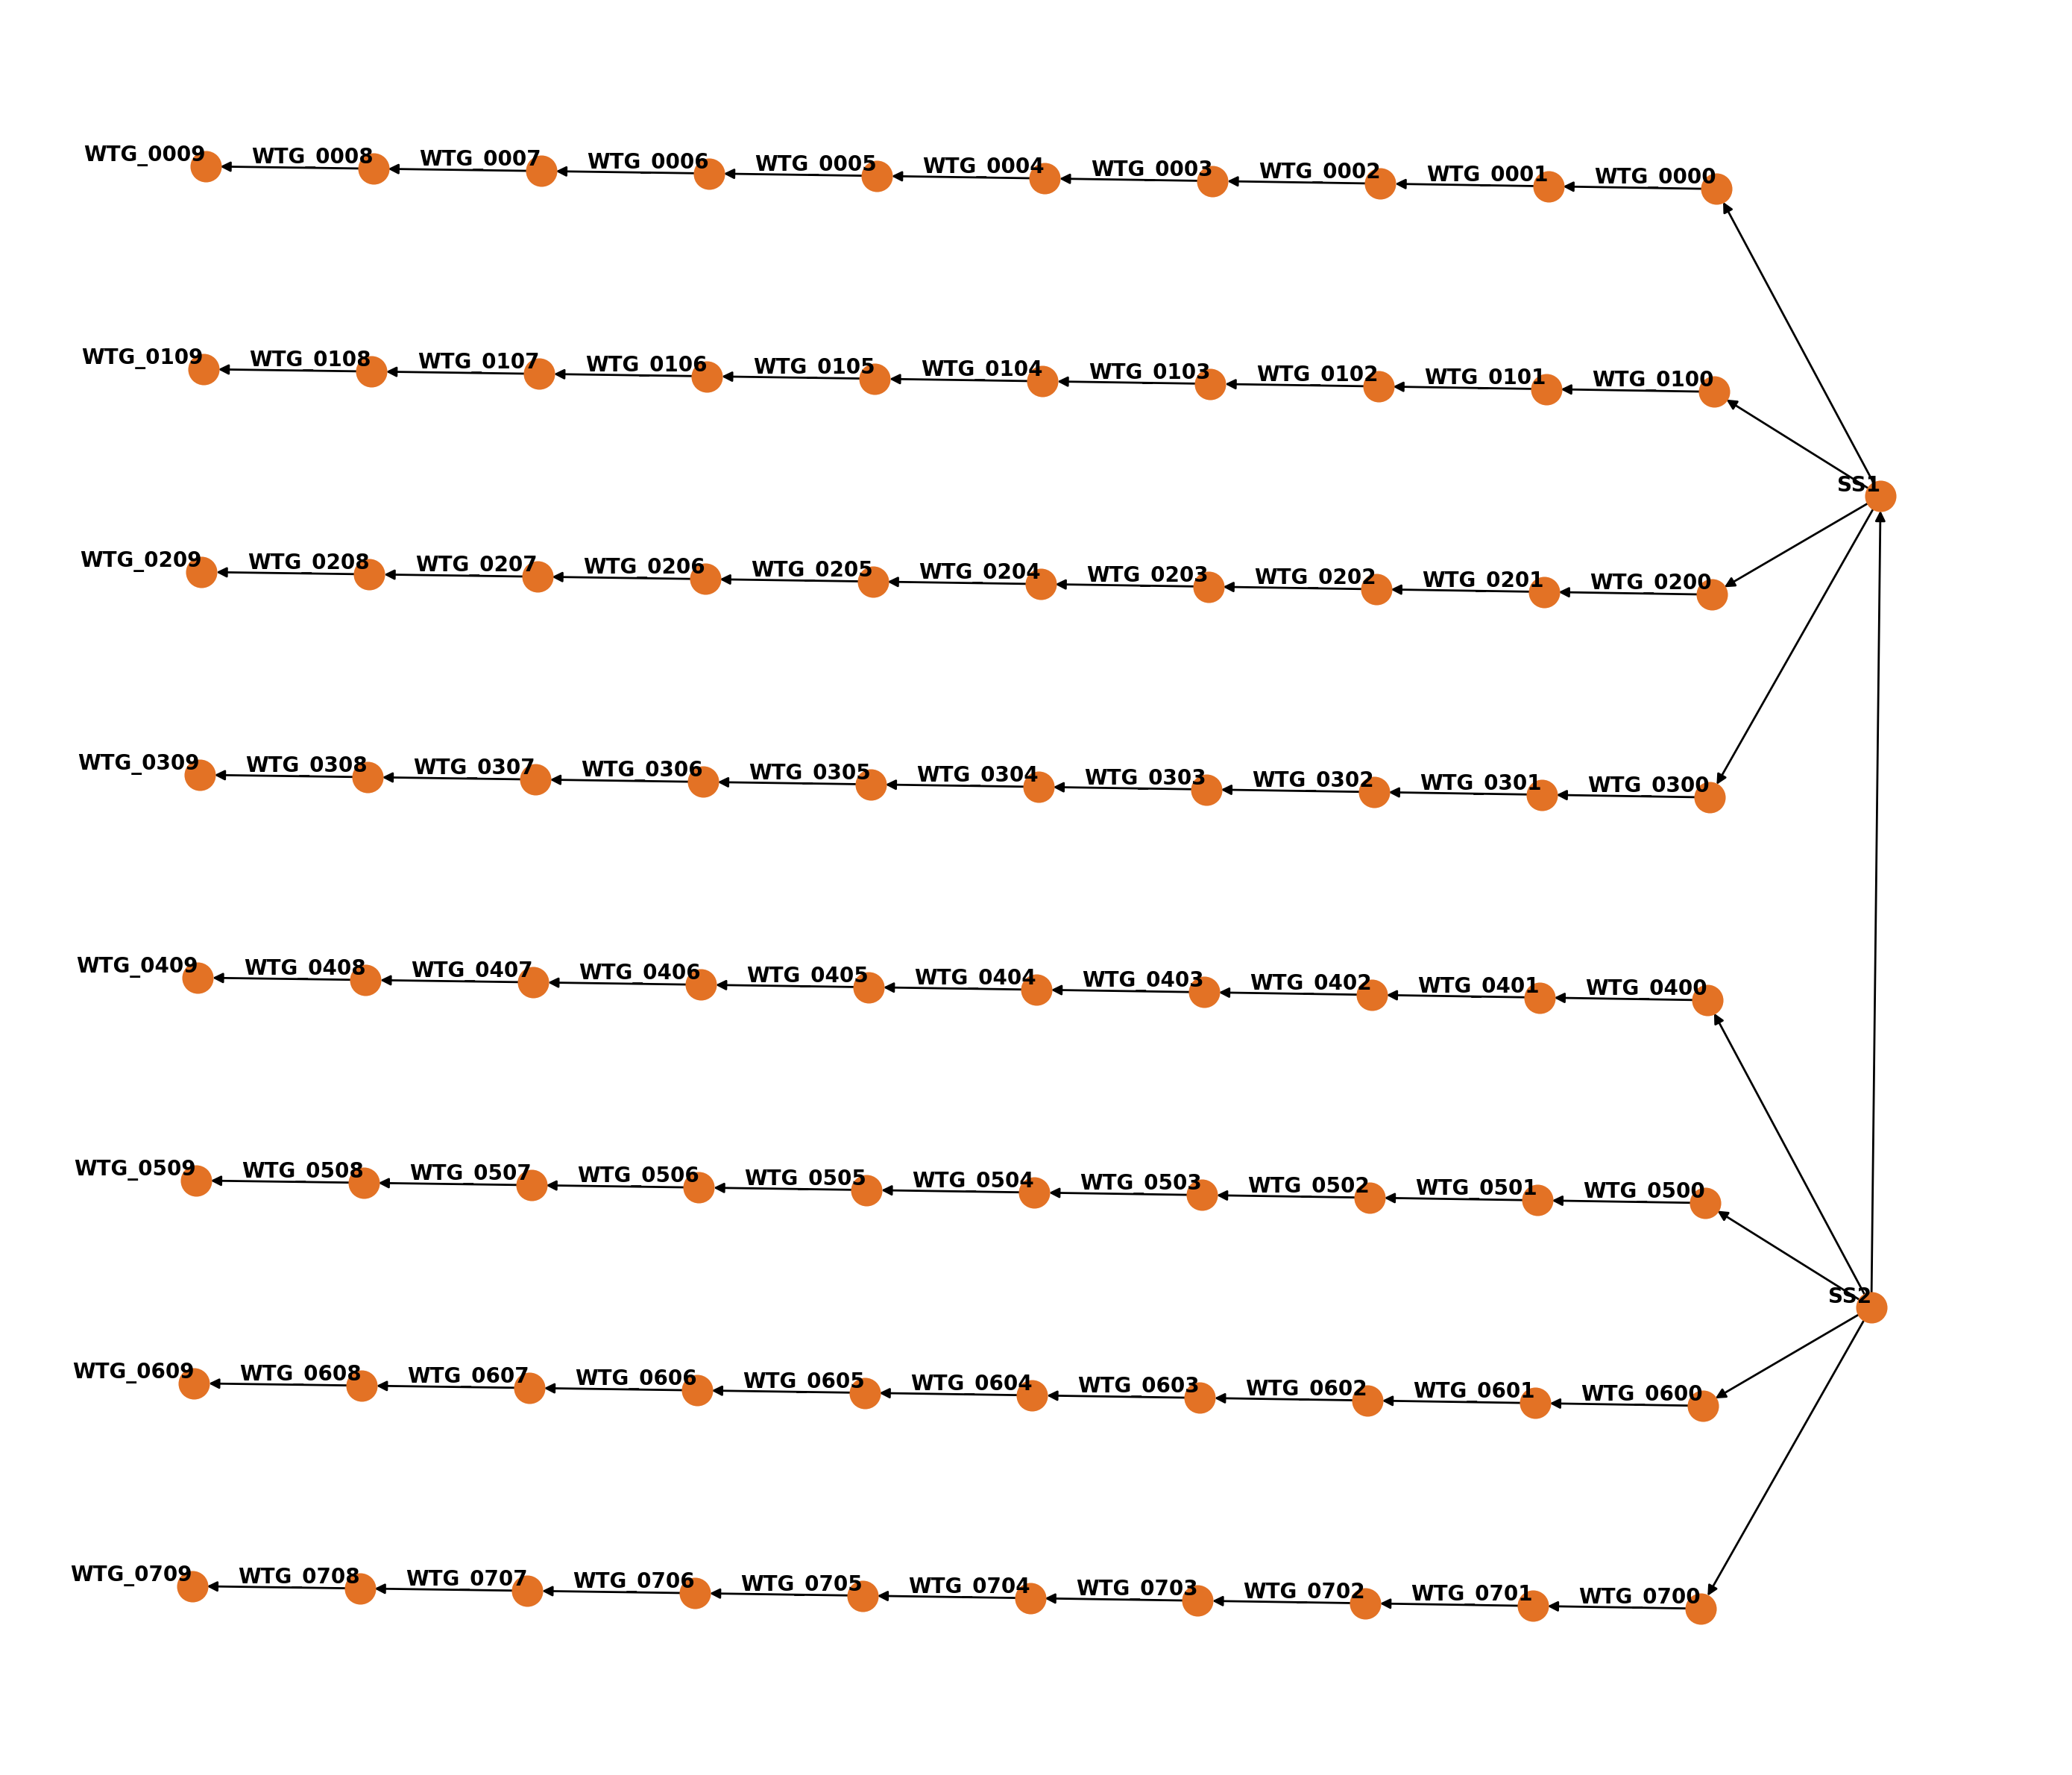

In [3]:
plot.plot_farm_layout(sim_in_situ.windfarm, plot_kwargs={"node_size": 200})

### Show some of the connections that `Simulation` creates that can be helpful for debugging

Sometimes simulations fail, and when that happens we might need to dig into what's going, which is often at the service equipment level because that is where much of the strategy configuration is coming from.

First, we'll see that simulations have a service equipment dictionary controlled by the `name` that we gave them.

In [4]:
list(sim_in_situ.service_equipment.keys())

['Crew Transfer Vessel 1',
 'Crew Transfer Vessel 2',
 'Crew Transfer Vessel 3',
 'Crew Transfer Vessel 4',
 'Crew Transfer Vessel 5',
 'Crew Transfer Vessel 6',
 'Crew Transfer Vessel 7',
 'Cable Laying Vessel',
 'Diving Support Vessel',
 'Anchor Handling Tug',
 'Heavy Lift Vessel']

In [5]:
list(sim_ttp.service_equipment.keys())

['Crew Transfer Vessel 1',
 'Crew Transfer Vessel 2',
 'Crew Transfer Vessel 3',
 'Crew Transfer Vessel 4',
 'Crew Transfer Vessel 5',
 'Crew Transfer Vessel 6',
 'Crew Transfer Vessel 7',
 'Cable Laying Vessel',
 'Diving Support Vessel',
 'Anchor Handling Tug',
 'Tugboat 1',
 'Tugboat 2']

Now, let's confirm that our work shifts are set up to be what we discussed.

In [6]:
sim_in_situ.service_equipment["Crew Transfer Vessel 1"].settings.workday_start

6

In [7]:
sim_in_situ.service_equipment["Heavy Lift Vessel"].settings.workday_start

0

## Run the simulations

To run a simulation, all we have to do is call `run()` and that will run it until the end of our configured simulation timeframe. Optionally, inputs such as `until=` can be used to control how many simulation hours the simulation will be run (1 year = 8760 hours, but be weary of leap years in your weather timeseries).

In [8]:
start = perf_counter()
sim_in_situ.run()
end = perf_counter()
print(f"Run time: {(end - start):.2f} seconds")

Run time: 85.53 seconds


In [9]:
start = perf_counter()
sim_ttp.run()
end = perf_counter()
print(f"Run time: {(end - start):.2f} seconds")

Run time: 285.59 seconds


## View the results

Now a `metrics` object will be available through the `Simulation` that gives access to the results methods, which provides all the metrics calculations that are pre-configured within WOMBAT, and gives access to the resulting energy, operations, and events logs.

### Availability

Note that the time-based availability is much higher than the production-based availability, which is due to the fact that the time basis cares about if the farm is operational at all, compared to the actual operational levels. If we were to dig into the individual turbines, we would find that the two availabilities would look similar, though the time-based would still trend higher.

In [10]:
print("In Situ Availability")
print(f'Time-based: {sim_in_situ.metrics.time_based_availability("project", "windfarm").values[0][0]:.2%}')
print(f'Production-based: {sim_in_situ.metrics.production_based_availability("project", "windfarm").values[0][0]:.2%}')
print()
print("Tow-to-Port Availability")
print(f'Time-based: {sim_ttp.metrics.time_based_availability("project", "windfarm").values[0][0]:.2%}')
print(f'Production-based: {sim_ttp.metrics.production_based_availability("project", "windfarm").values[0][0]:.2%}')

In Situ Availability
Time-based: 99.36%
Production-based: 89.20%

Tow-to-Port Availability
Time-based: 98.14%
Production-based: 92.49%


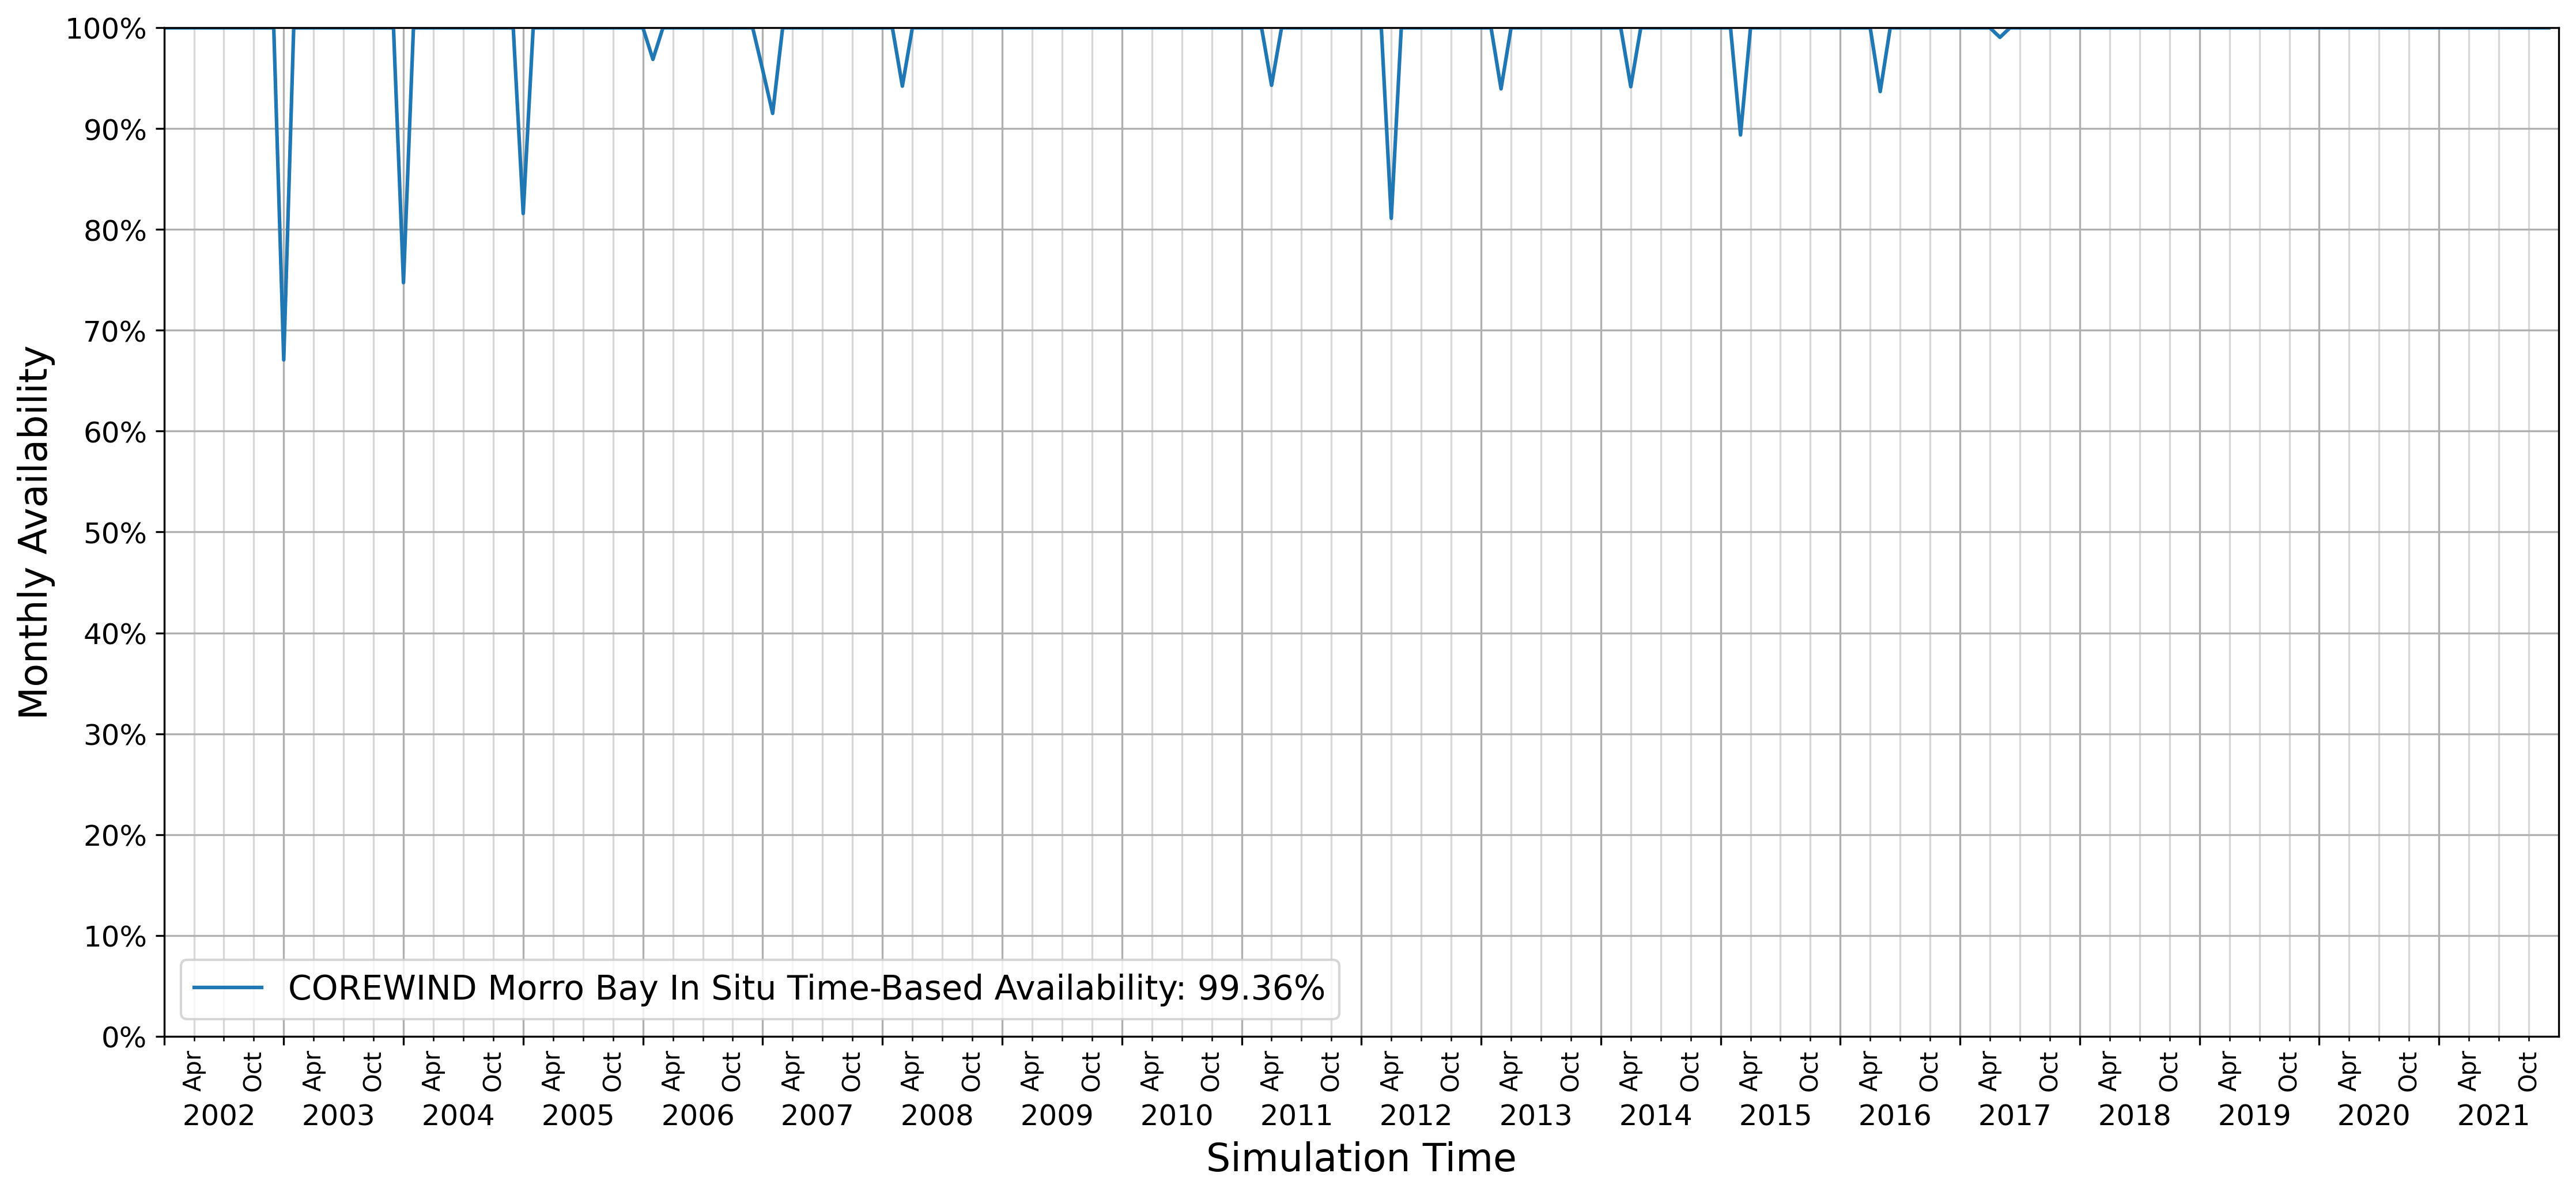

In [11]:
plot.plot_farm_availability(sim_in_situ, which="time")

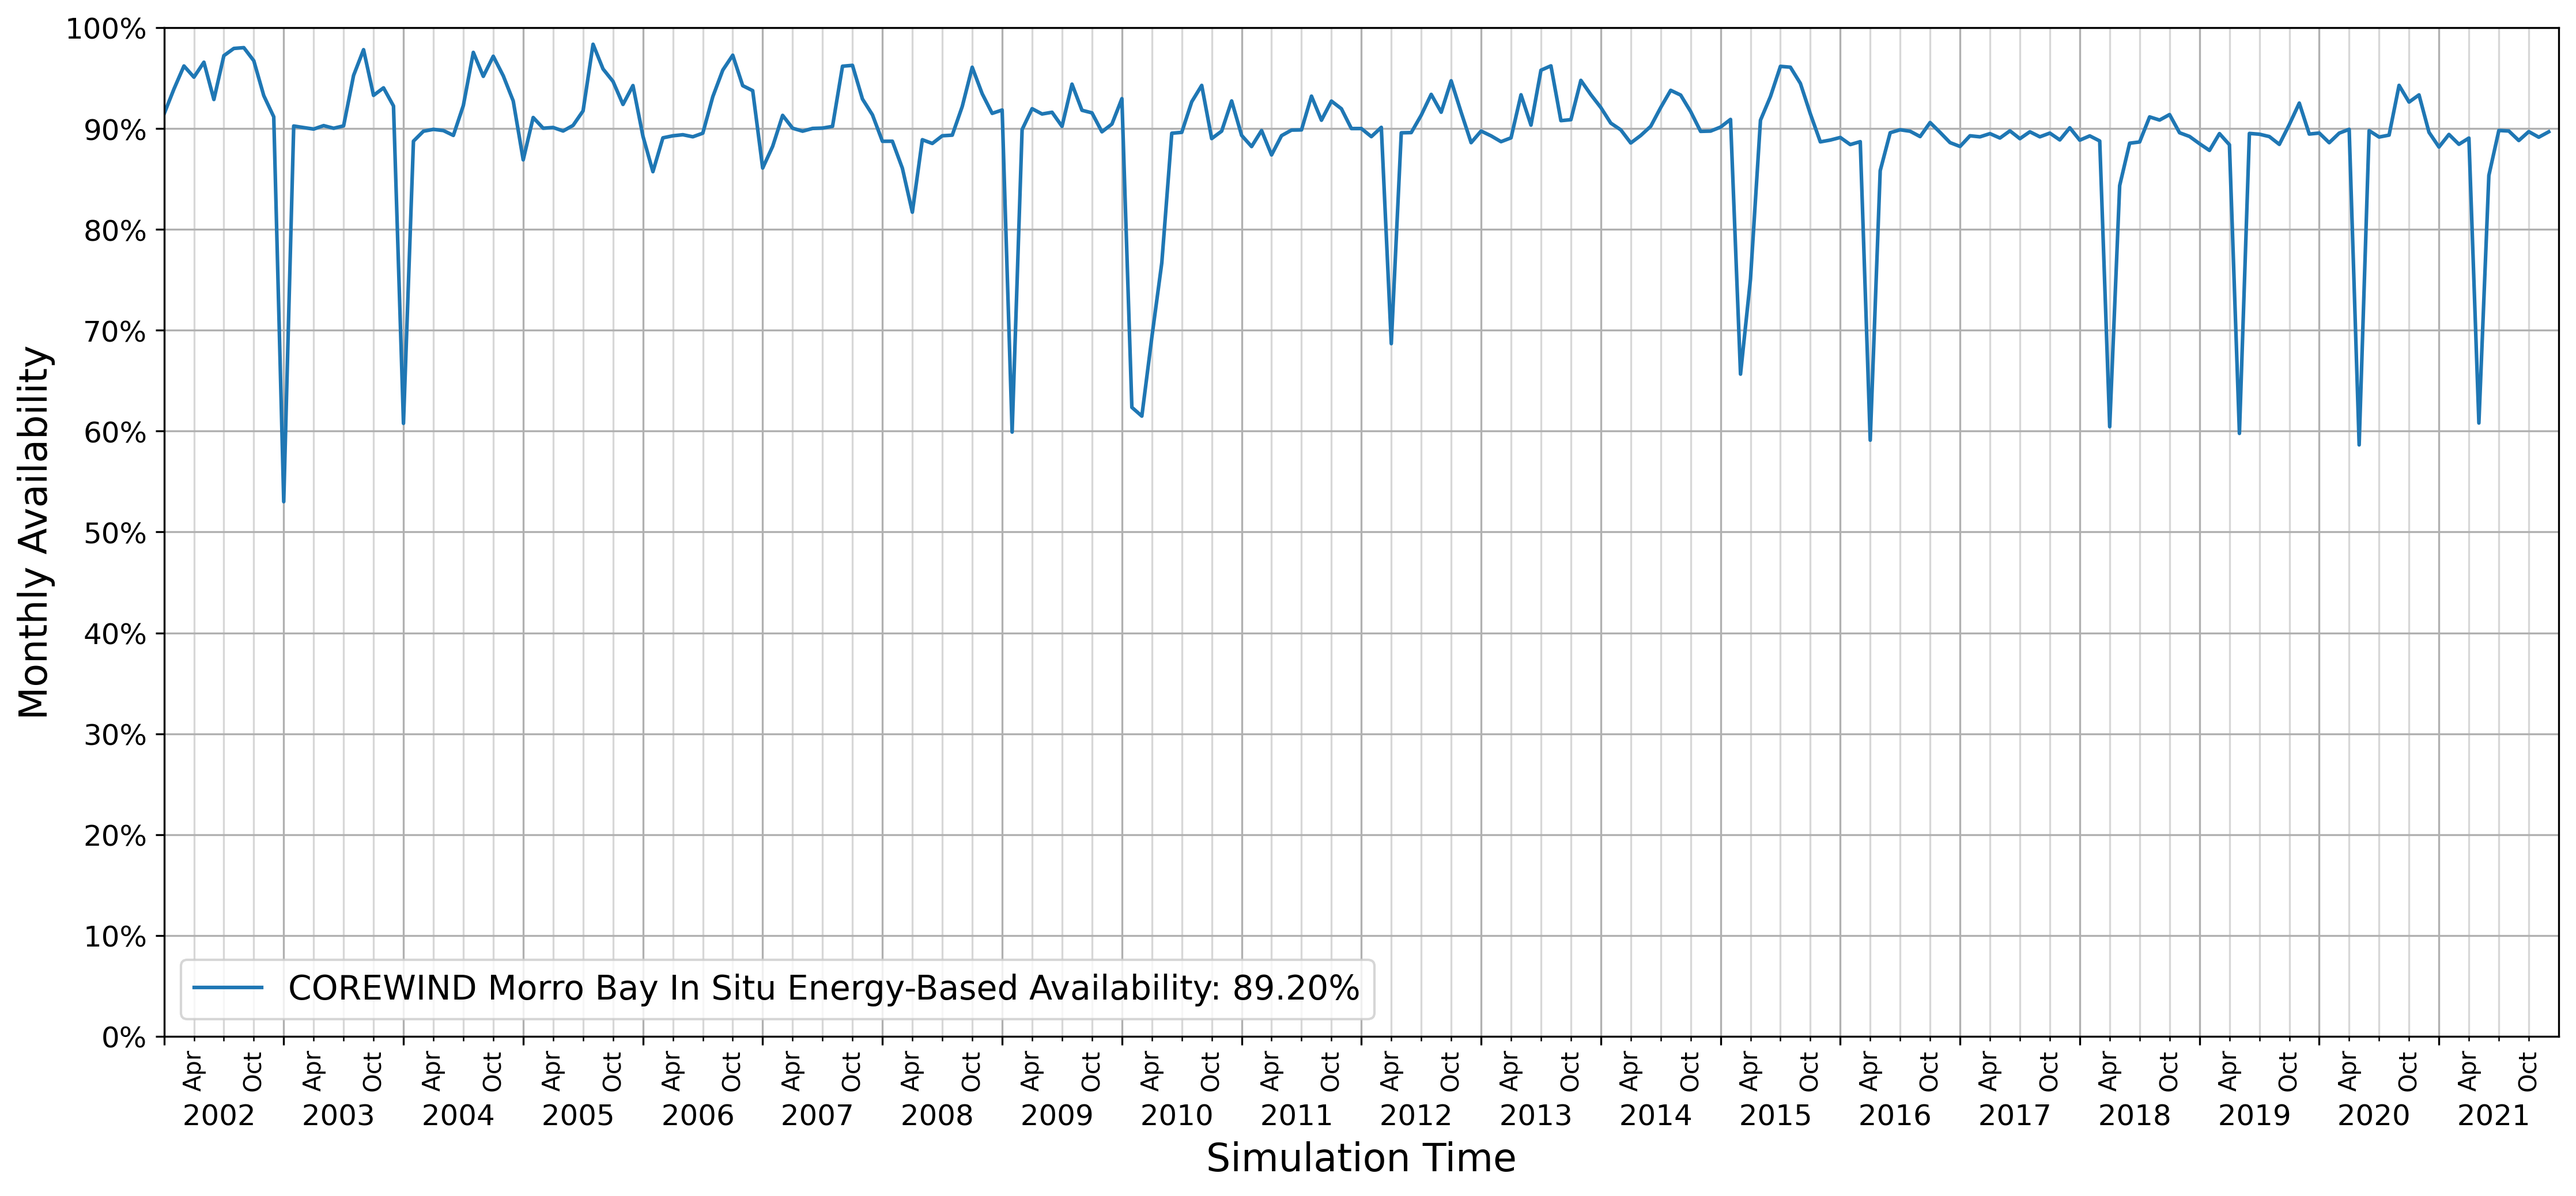

In [12]:
plot.plot_farm_availability(sim_in_situ, which="energy")

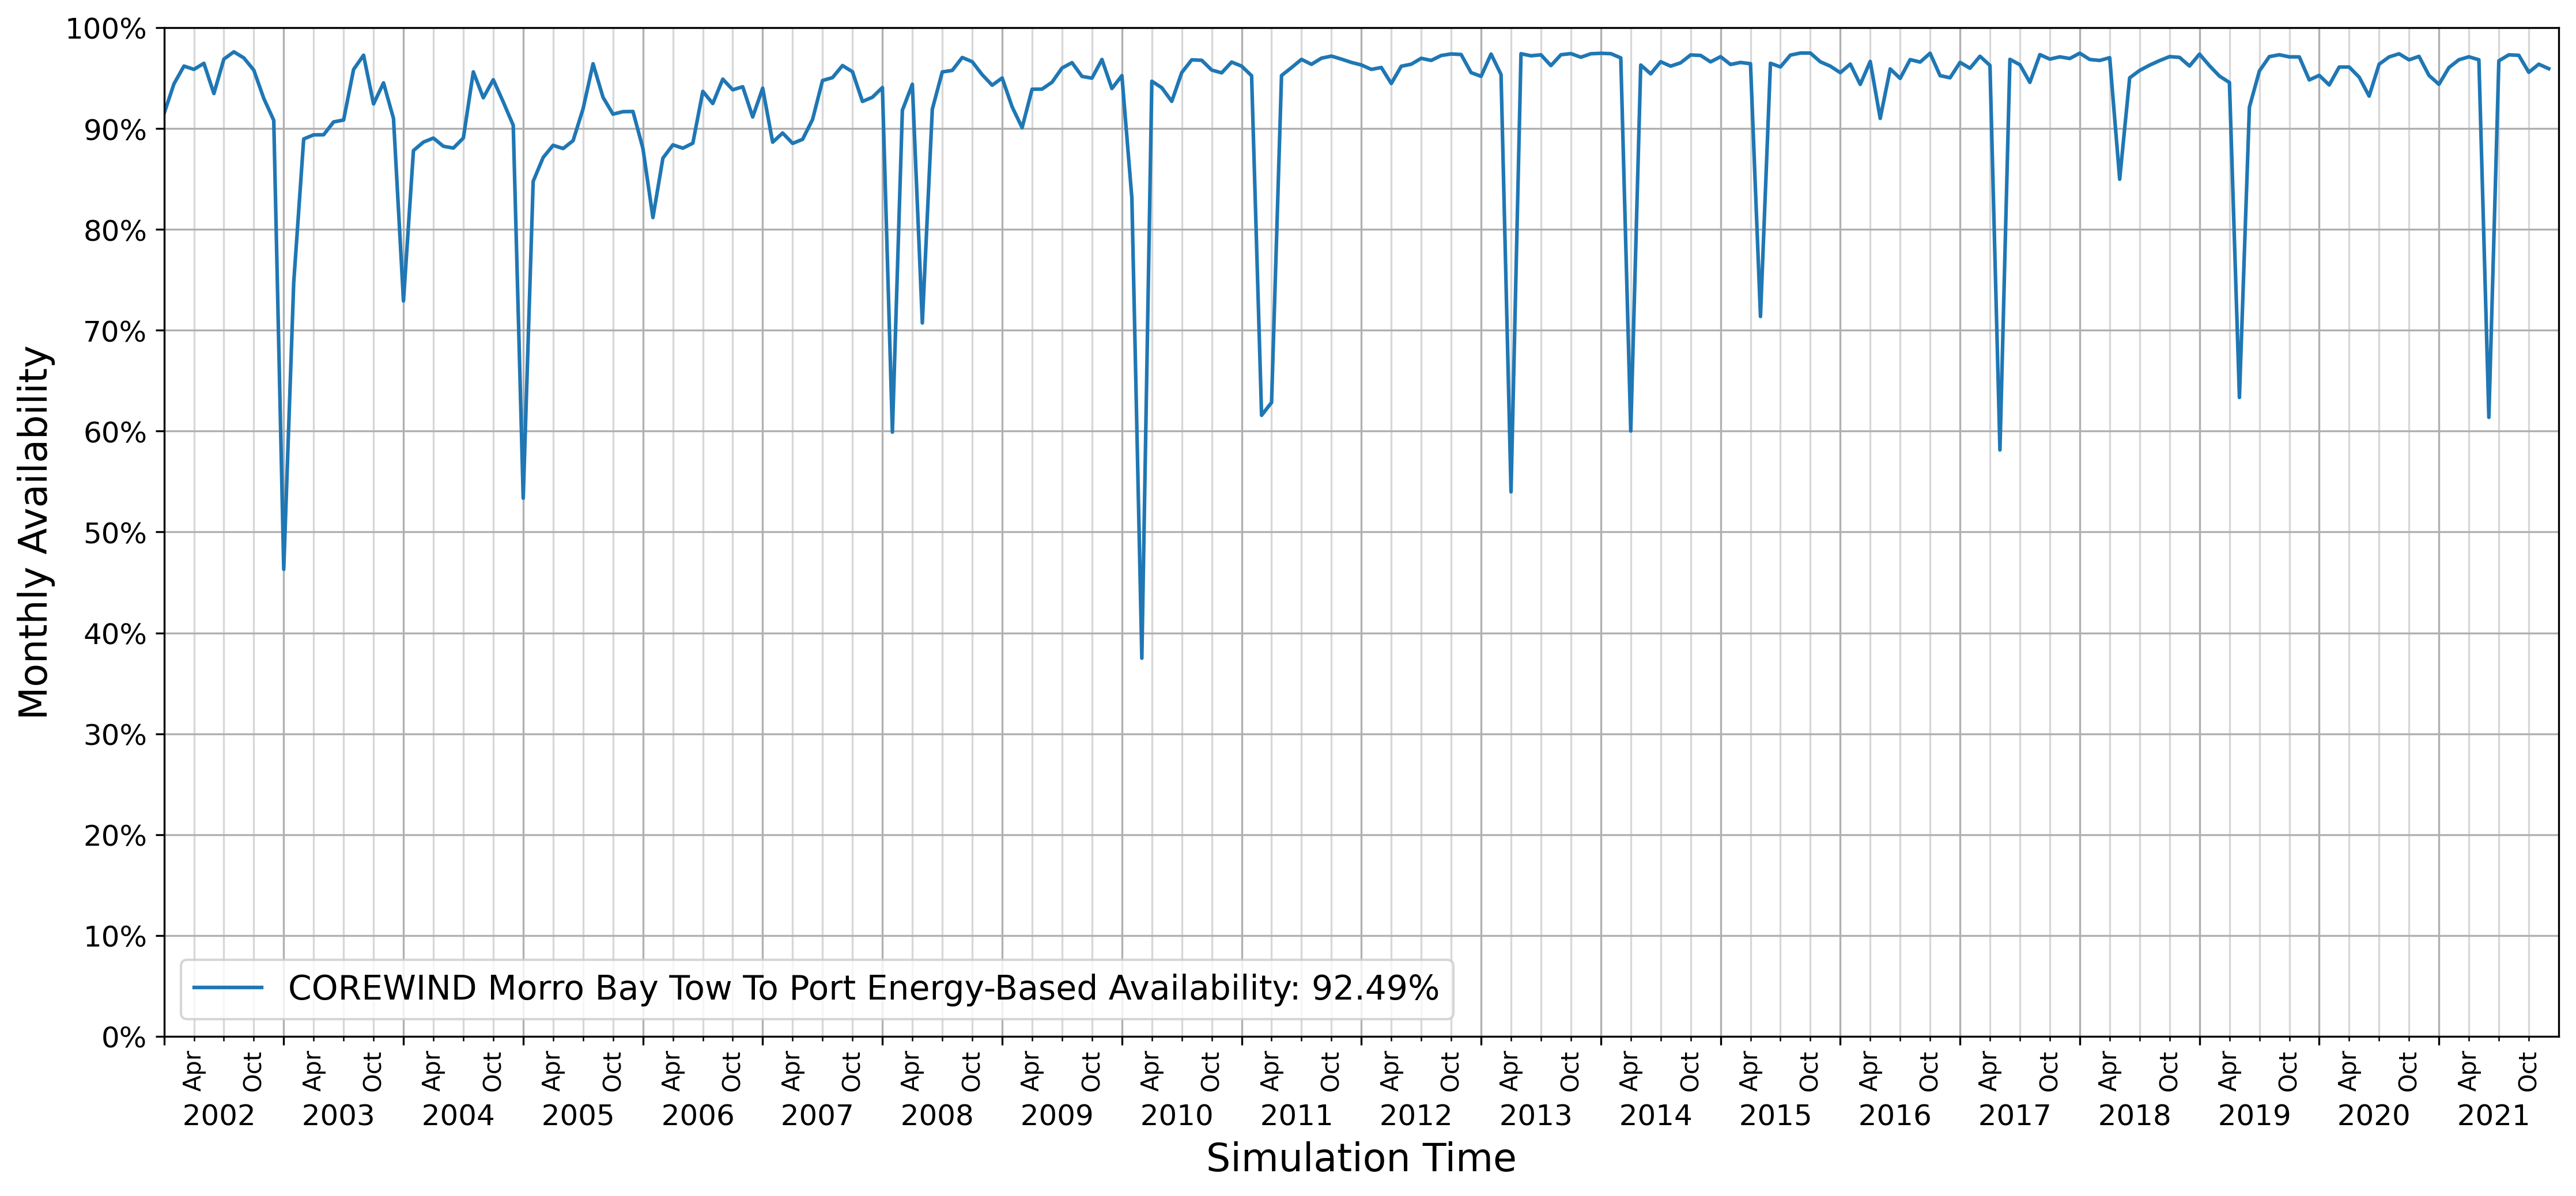

In [13]:
plot.plot_farm_availability(sim_ttp)

In the in situ case, we can see a large dip in availability in January 2003, and in the tow-to-port case we can see a large dip around February 2007, so let's investiage a bit further by diving into the events and operations logs that are available through the `Metrics` object.

In [14]:
ev_in_situ = sim_in_situ.metrics.events
op_in_situ = sim_in_situ.metrics.operations

In [15]:
op_in_situ.head()

env_datetime  env_time  WTG_0000  WTG_0001  \
datetime                                                                       
2023-10-26 11:50:35.814094 2002-01-01 00:00:00         0         1         1   
2023-10-26 11:50:35.833984 2002-01-01 01:00:00         1         1         1   
2023-10-26 11:50:35.834149 2002-01-01 02:00:00         2         1         1   
2023-10-26 11:50:35.834229 2002-01-01 03:00:00         3         1         1   
2023-10-26 11:50:35.834306 2002-01-01 04:00:00         4         1         1   

                            WTG_0002  WTG_0003  WTG_0004  WTG_0005  WTG_0006  \
datetime                                                                       
2023-10-26 11:50:35.814094         1         1         1         1         1   
2023-10-26 11:50:35.833984         1         1         1         1         1   
2023-10-26 11:50:35.834149         1         1         1         1         1   
2023-10-26 11:50:35.834229         1         1         1         1         1   
2023-10-26 11:50:35.834306         1         1         1         1         1   

                            WTG_0007  WTG_0008  WTG_0009  WTG_0100  WTG_0101  \
datetime                                                                       
2023-10-26 11:50:35.814094         1         1         1         1         1   
2023-10-26 11:50:35.833984         1         1         1         1         1   
2023-10-26 11:50:35.834149         1         1         1         1         1   
2023-10-26 11:50:35.834229         1         1         1         1         1   
2023-10-26 11:50:35.834306         1         1         1         1         1   

                            WTG_0102  WTG_0103  WTG_0104  WTG_0105  WTG_0106  \
datetime                                                                       
2023-10-26 11:50:35.814094         1         1         1         1         1   
2023-10-26 11:50:35.833984         1         1         1         1         1   
2023-10-26 11:50:35.834149         1         1         1         1         1   
2023-10-26 11:50:35.834229         1         1         1         1         1   
2023-10-26 11:50:35.834306         1         1         1         1         1   

                            WTG_0107  WTG_0108  WTG_0109  WTG_0200  WTG_0201  \
datetime                                                                       
2023-10-26 11:50:35.814094         1         1         1         1         1   
2023-10-26 11:50:35.833984         1         1         1         1         1   
2023-10-26 11:50:35.834149         1         1         1         1         1   
2023-10-26 11:50:35.834229         1         1         1         1         1   
2023-10-26 11:50:35.834306         1         1         1         1         1   

                            WTG_0202  WTG_0203  WTG_0204  WTG_0205  WTG_0206  \
datetime                                                                       
2023-10-26 11:50:35.814094         1         1         1         1         1   
2023-10-26 11:50:35.833984         1         1         1         1         1   
2023-10-26 11:50:35.834149         1         1         1         1         1   
2023-10-26 11:50:35.834229         1         1         1         1         1   
2023-10-26 11:50:35.834306         1         1         1         1         1   

                            WTG_0207  WTG_0208  WTG_0209  WTG_0300  WTG_0301  \
datetime                                                                       
2023-10-26 11:50:35.814094         1         1         1         1         1   
2023-10-26 11:50:35.833984         1         1         1         1         1   
2023-10-26 11:50:35.834149         1         1         1         1         1   
2023-10-26 11:50:35.834229         1         1         1         1         1   
2023-10-26 11:50:35.834306         1         1         1         1         1   

                            WTG_0302  WTG_0303  WTG_0304  WTG_0305  WTG_0306  \
datetime                   

In [16]:
op_in_situ.loc[op_in_situ.windfarm < 0.45, ["env_datetime", "env_time", "windfarm"]].head(24)

env_datetime  env_time  windfarm
datetime                                                          
2023-10-26 11:50:37.783638 2003-01-20 11:00:00      9227    0.4375
2023-10-26 11:50:37.783910 2003-01-20 12:00:00      9228       0.0
2023-10-26 11:50:37.783980 2003-01-20 13:00:00      9229       0.0
2023-10-26 11:50:37.784044 2003-01-20 14:00:00      9230       0.0
2023-10-26 11:50:37.786237 2003-01-20 15:00:00      9231       0.0
2023-10-26 11:50:37.786428 2003-01-20 16:00:00      9232       0.0
2023-10-26 11:50:37.786499 2003-01-20 17:00:00      9233       0.0
2023-10-26 11:50:37.786637 2003-01-20 18:00:00      9234       0.0
2023-10-26 11:50:37.787928 2003-01-20 19:00:00      9235       0.0
2023-10-26 11:50:37.789044 2003-01-20 20:00:00      9236       0.0
2023-10-26 11:50:37.789116 2003-01-20 21:00:00      9237       0.0
2023-10-26 11:50:37.790587 2003-01-20 22:00:00      9238       0.0
2023-10-26 11:50:37.790729 2003-01-20 23:00:00      9239       0.0
2023-10-26 11:50:37.790921 2003-01-21 00:00:00      9240       0.0
2023-10-26 11:50:37.790984 2003-01-21 01:00:00      9241       0.0
2023-10-26 11:50:37.791046 2003-01-21 02:00:00      9242       0.0
2023-10-26 11:50:37.791111 2003-01-21 03:00:00      9243       0.0
2023-10-26 11:50:37.791173 2003-01-21 04:00:00      9244       0.0
2023-10-26 11:50:37.791237 2003-01-21 05:00:00      9245       0.0
2023-10-26 11:50:37.792320 2003-01-21 06:00:00      9246       0.0
2023-10-26 11:50:37.792423 2003-01-21 07:00:00      9247       0.0
2023-10-26 11:50:37.792963 2003-01-21 08:00:00      9248       0.0
2023-10-26 11:50:37.793906 2003-01-21 09:00:00      9249       0.0
2023-10-26 11:50:37.795220 2003-01-21 10:00:00      9250       0.0

In [17]:
ev_in_situ.head().T  # transposed because of a bug in Jupyter Lab 4.0

datetime                                       2023-10-26 11:50:32.070895  \
env_datetime                                          2002-01-01 00:00:00   
env_time                                                              0.0   
agent                                                            WTG_0000   
action                  subassemblies created: ['electrical_system', '...   
reason                                            windfarm initialization   
additional                                                 initialization   
system_id                                                        WTG_0000   
system_name                                                      WTG_0000   
part_id                                                              <NA>   
part_name                                                            <NA>   
system_operating_level                                                  1   
part_operating_level                                                    1   
duration                                                              0.0   
distance_km                                                           0.0   
request_id                                                             na   
location                                                               na   
materials_cost                                                          0   
hourly_labor_cost                                                       0   
salary_labor_cost                                                     0.0   
total_labor_cost                                                      0.0   
equipment_cost                                                        0.0   
total_cost                                                            0.0   
year                                                                 2002   
month                                                                   1   
day                                                                     1   

datetime                                       2023-10-26 11:50:32.077281  \
env_datetime                                          2002-01-01 00:00:00   
env_time                                                              0.0   
agent                                                            WTG_0001   
action                  subassemblies created: ['electrical_system', '...   
reason                                            windfarm initialization   
additional                                                 initialization   
system_id                                                        WTG_0001   
system_name                                                      WTG_0001   
part_id                                                              <NA>   
part_name                                                            <NA>   
system_operating_level                                                  1   
part_operating_level                                                    1   
duration                                                              0.0   
distance_km                                                           0.0   
request_id                                                             na   
location                                                               na   
materials_cost                                                          0   
hourly_labor_cost                                                       0   
salary_labor_cost                                                     0.0   
total_labor_cost                                                      0.0   
equipment_cost                                                        0.0   
total_cost                                                            0.0   
year                                                                 2002   
month                                                                   1   
day                                                                     

In [18]:
# Get the core subset of columns to show
col_filter = ["env_datetime", "agent", "action", "reason", "additional", "system_id", "part_id", "request_id", "duration"]

So let's look for anything that seems like it could cause some major downtime around this timeframe.

In [19]:
ev_in_situ.loc[
    ev_in_situ.env_datetime >= "2003-01-20",
    col_filter
].head(50)

env_datetime                   agent  \
datetime                                                                 
2023-10-26 11:50:37.778064 2003-01-20 06:00:00  Crew Transfer Vessel 5   
2023-10-26 11:50:37.778203 2003-01-20 06:00:00  Crew Transfer Vessel 3   
2023-10-26 11:50:37.778341 2003-01-20 06:00:00  Crew Transfer Vessel 6   
2023-10-26 11:50:37.778477 2003-01-20 06:00:00  Crew Transfer Vessel 1   
2023-10-26 11:50:37.778614 2003-01-20 06:00:00  Crew Transfer Vessel 4   
2023-10-26 11:50:37.778749 2003-01-20 06:00:00  Crew Transfer Vessel 2   
2023-10-26 11:50:37.778882 2003-01-20 06:00:00  Crew Transfer Vessel 7   
2023-10-26 11:50:37.779019 2003-01-20 07:48:34  Crew Transfer Vessel 5   
2023-10-26 11:50:37.779088 2003-01-20 07:48:34  Crew Transfer Vessel 5   
2023-10-26 11:50:37.779098 2003-01-20 07:48:35  Crew Transfer Vessel 3   
2023-10-26 11:50:37.779161 2003-01-20 07:48:35  Crew Transfer Vessel 3   
2023-10-26 11:50:37.779167 2003-01-20 07:48:35  Crew Transfer Vessel 6   
2023-10-26 11:50:37.779228 2003-01-20 07:48:35  Crew Transfer Vessel 6   
2023-10-26 11:50:37.779234 2003-01-20 07:48:35  Crew Transfer Vessel 1   
2023-10-26 11:50:37.779293 2003-01-20 07:48:35  Crew Transfer Vessel 1   
2023-10-26 11:50:37.779299 2003-01-20 07:48:35  Crew Transfer Vessel 4   
2023-10-26 11:50:37.779359 2003-01-20 07:48:35  Crew Transfer Vessel 4   
2023-10-26 11:50:37.779365 2003-01-20 07:48:35  Crew Transfer Vessel 2   
2023-10-26 11:50:37.779423 2003-01-20 07:48:35  Crew Transfer Vessel 2   
2023-10-26 11:50:37.779429 2003-01-20 07:48:36  Crew Transfer Vessel 7   
2023-10-26 11:50:37.779491 2003-01-20 07:48:36  Crew Transfer Vessel 7   
2023-10-26 11:50:37.779560 2003-01-20 08:03:34  Crew Transfer Vessel 5   
2023-10-26 11:50:37.779648 2003-01-20 08:03:34  Crew Transfer Vessel 5   
2023-10-26 11:50:37.779654 2003-01-20 08:03:35  Crew Transfer Vessel 3   
2023-10-26 11:50:37.779916 2003-01-20 08:03:35  Crew Transfer Vessel 3   
2023-10-26 11:50:37.779922 2003-01-20 08:03:35  Crew Transfer Vessel 6   
2023-10-26 11:50:37.780101 2003-01-20 08:03:35  Crew Transfer Vessel 6   
2023-10-26 11:50:37.780109 2003-01-20 08:03:35  Crew Transfer Vessel 1   
2023-10-26 11:50:37.780229 2003-01-20 08:03:35  Crew Transfer Vessel 1   
2023-10-26 11:50:37.780235 2003-01-20 08:03:35  Crew Transfer Vessel 4   
2023-10-26 11:50:37.780340 2003-01-20 08:03:35  Crew Transfer Vessel 4   
2023-10-26 11:50:37.780346 2003-01-20 08:03:35  Crew Transfer Vessel 2   
2023-10-26 11:50:37.780449 2003-01-20 08:03:35  Crew Transfer Vessel 2   
2023-10-26 11:50:37.780455 2003-01-20 08:03:36  Crew Transfer Vessel 7   
2023-10-26 11:50:37.780559 2003-01-20 08:03:36  Crew Transfer Vessel 7   
2023-10-26 11:50:37.780631 2003-01-20 08:28:12  Crew Transfer Vessel 5   
2023-10-26 11:50:37.780637 2003-01-20 08:43:12  Crew Transfer Vessel 5   
2023-10-26 11:50:37.780780 2003-01-20 08:43:12  Crew Transfer Vessel 5   
2023-10-26 11:50:37.781404 2003-01-20 08:43:14  Crew Transfer Vessel 5   
2023-10-26 11:50:37.781412 2003-01-20 08:54:19  Crew Transfer Vessel 5   
2023-10-26 11:50:37.781673 2003-01-20 08:54:19  Crew Transfer Vessel 5   
2023-10-26 11:50:37.781746 2003-01-20 09:09:19  Crew Transfer Vessel 5   
2023-10-26 11:50:37.781847 2003-01-20 09:09:19  Crew Transfer Vessel 5   
2023-10-26 11:50:37.781919 2003-01-20 09:39:47  Crew Transfer Vessel 2   
2023-10-26 11:50:37.781924 2003-01-20 09:54:47  Crew Transfer Vessel 2   
2023-10-26 11:50:37.781976 2003-01-20 09:54:47  Crew Transfer Vessel 2   
2023-10-26 11:50:37.782602 2003-01-20 09:54:56  Crew Transfer Vessel 2   
2023-10-26 11:50:37.782679 2003-01-20 10:07:41  Crew Transfer Vessel 2   
2023-10-26 11:50:37.782775 2003-01-20 10:07:41  Crew Transfer Vessel 2   
2023-10-26 11:50:37.782781 2003-01-20 10:22:41  Crew Transfer Vessel 2   

                                       action  \
datetime                                        
2023-10-26 11:50:37.778064          traveling   
2023-10-26 11:50:37.778203          tr

So, we have a substation inspection, so in order to operate on that it'll get shut down, which then shuts down all energy passing through it, which could cause some major curtailment. Now, let's see how long that might be lasting

In [20]:
ev_in_situ.loc[
    ev_in_situ.env_datetime >= "2003-01-20 09:50",
    col_filter
].head(20)

env_datetime                   agent  \
datetime                                                                 
2023-10-26 11:50:37.781924 2003-01-20 09:54:47  Crew Transfer Vessel 2   
2023-10-26 11:50:37.781976 2003-01-20 09:54:47  Crew Transfer Vessel 2   
2023-10-26 11:50:37.782602 2003-01-20 09:54:56  Crew Transfer Vessel 2   
2023-10-26 11:50:37.782679 2003-01-20 10:07:41  Crew Transfer Vessel 2   
2023-10-26 11:50:37.782775 2003-01-20 10:07:41  Crew Transfer Vessel 2   
2023-10-26 11:50:37.782781 2003-01-20 10:22:41  Crew Transfer Vessel 2   
2023-10-26 11:50:37.782876 2003-01-20 10:22:41  Crew Transfer Vessel 2   
2023-10-26 11:50:37.782949 2003-01-20 10:36:27  Crew Transfer Vessel 7   
2023-10-26 11:50:37.782955 2003-01-20 10:51:27  Crew Transfer Vessel 7   
2023-10-26 11:50:37.783007 2003-01-20 10:51:27  Crew Transfer Vessel 7   
2023-10-26 11:50:37.783632 2003-01-20 10:51:33  Crew Transfer Vessel 7   
2023-10-26 11:50:37.783706 2003-01-20 11:19:36  Crew Transfer Vessel 7   
2023-10-26 11:50:37.783803 2003-01-20 11:19:36  Crew Transfer Vessel 7   
2023-10-26 11:50:37.783809 2003-01-20 11:34:36  Crew Transfer Vessel 7   
2023-10-26 11:50:37.783905 2003-01-20 11:34:36  Crew Transfer Vessel 7   
2023-10-26 11:50:37.784173 2003-01-20 14:10:47  Crew Transfer Vessel 3   
2023-10-26 11:50:37.784239 2003-01-20 14:10:47  Crew Transfer Vessel 4   
2023-10-26 11:50:37.784246 2003-01-20 14:25:47  Crew Transfer Vessel 3   
2023-10-26 11:50:37.784296 2003-01-20 14:25:47  Crew Transfer Vessel 3   
2023-10-26 11:50:37.784842 2003-01-20 14:25:47  Crew Transfer Vessel 4   

                                       action  \
datetime                                        
2023-10-26 11:50:37.781924  complete transfer   
2023-10-26 11:50:37.781976    repair complete   
2023-10-26 11:50:37.782602          traveling   
2023-10-26 11:50:37.782679    complete travel   
2023-10-26 11:50:37.782775  transferring crew   
2023-10-26 11:50:37.782781  complete transfer   
2023-10-26 11:50:37.782876        maintenance   
2023-10-26 11:50:37.782949  transferring crew   
2023-10-26 11:50:37.782955  complete transfer   
2023-10-26 11:50:37.783007    repair complete   
2023-10-26 11:50:37.783632          traveling   
2023-10-26 11:50:37.783706    complete travel   
2023-10-26 11:50:37.783803  transferring crew   
2023-10-26 11:50:37.783809  complete transfer   
2023-10-26 11:50:37.783905        maintenance   
2023-10-26 11:50:37.784173  transferring crew   
2023-10-26 11:50:37.784239  transferring crew   
2023-10-26 11:50:37.784246  complete transfer   
2023-10-26 11:50:37.784296    repair complete   
2023-10-26 11:50:37.784842  complete transfer   

                                                         reason  \
datetime                                                          
2023-10-26 11:50:37.781924  direct drive generator minor repair   
2023-10-26 11:50:37.781976  direct drive generator minor repair   
2023-10-26 11:50:37.782602                oss annual inspection   
2023-10-26 11:50:37.782679                oss annual inspection   
2023-10-26 11:50:37.782775                oss annual inspection   
2023-10-26 11:50:37.782781                oss annual inspection   
2023-10-26 11:50:37.782876                oss annual inspection   
2023-10-26 11:50:37.782949                  blades minor repair   
2023-10-26 11:50:37.782955                  blades minor repair   
2023-10-26 11:50:37.783007                  blades minor repair   
2023-10-26 11:50:37.783632                oss annual inspection   
2023-10-26 11:50:37.783706                oss annual inspection   
2023-10-26 11:50:37.783803                oss annual inspection   
2023-10-26 11:50:37.783809                oss annual inspection   
2023-10-26 11:50:37.783905                oss annual inspection   
2023-10-26 11:50:37.784173            major pitch system repair   
2023-10-26 11:50:37.784239            major pitch system repair   
2023-10-26 11:50:37.784246            major pitch sys

Ok, so now it's clear that both substations are having simultaneous downtime, which will inevitable shut down the whole farm. Let's just see how long that might last for

In [21]:
ss1_maint = ev_in_situ.loc[
    ev_in_situ.request_id == "MNT00000325",
    col_filter
]
ss1_maint

env_datetime                   agent  \
datetime                                                                 
2023-10-26 11:50:37.673305 2003-01-01 00:00:00             transformer   
2023-10-26 11:50:37.782602 2003-01-20 09:54:56  Crew Transfer Vessel 2   
2023-10-26 11:50:37.782679 2003-01-20 10:07:41  Crew Transfer Vessel 2   
2023-10-26 11:50:37.782775 2003-01-20 10:07:41  Crew Transfer Vessel 2   
2023-10-26 11:50:37.782781 2003-01-20 10:22:41  Crew Transfer Vessel 2   
2023-10-26 11:50:37.782876 2003-01-20 10:22:41  Crew Transfer Vessel 2   
2023-10-26 11:50:37.789377 2003-01-20 21:45:00  Crew Transfer Vessel 2   
2023-10-26 11:50:37.789925 2003-01-20 22:00:00  Crew Transfer Vessel 2   
2023-10-26 11:50:37.790052 2003-01-20 22:00:00  Crew Transfer Vessel 2   
2023-10-26 11:50:37.790836 2003-01-20 23:48:35  Crew Transfer Vessel 2   
2023-10-26 11:50:37.790848 2003-01-20 23:48:35  Crew Transfer Vessel 2   
2023-10-26 11:50:37.791487 2003-01-21 06:00:00  Crew Transfer Vessel 2   
2023-10-26 11:50:37.792490 2003-01-21 07:48:35  Crew Transfer Vessel 2   
2023-10-26 11:50:37.792561 2003-01-21 07:48:35  Crew Transfer Vessel 2   
2023-10-26 11:50:37.793031 2003-01-21 08:03:35  Crew Transfer Vessel 2   
2023-10-26 11:50:37.793140 2003-01-21 08:03:35  Crew Transfer Vessel 2   
2023-10-26 11:50:37.797296 2003-01-21 17:00:00  Crew Transfer Vessel 2   
2023-10-26 11:50:37.798315 2003-01-21 23:00:00  Crew Transfer Vessel 2   
2023-10-26 11:50:37.799411 2003-01-22 00:48:35  Crew Transfer Vessel 2   
2023-10-26 11:50:37.799420 2003-01-22 00:48:35  Crew Transfer Vessel 2   
2023-10-26 11:50:37.800941 2003-01-22 22:00:00  Crew Transfer Vessel 2   
2023-10-26 11:50:37.801978 2003-01-23 06:00:00  Crew Transfer Vessel 2   
2023-10-26 11:50:37.802952 2003-01-23 07:48:35  Crew Transfer Vessel 2   
2023-10-26 11:50:37.803133 2003-01-23 07:48:35  Crew Transfer Vessel 2   
2023-10-26 11:50:37.804207 2003-01-23 09:25:46  Crew Transfer Vessel 2   
2023-10-26 11:50:37.804216 2003-01-23 09:25:46  Crew Transfer Vessel 2   
2023-10-26 11:50:37.805191 2003-01-23 22:00:00  Crew Transfer Vessel 2   
2023-10-26 11:50:37.806380 2003-01-24 06:00:00  Crew Transfer Vessel 2   
2023-10-26 11:50:37.807524 2003-01-24 07:48:36  Crew Transfer Vessel 2   
2023-10-26 11:50:37.807700 2003-01-24 07:48:36  Crew Transfer Vessel 2   
2023-10-26 11:50:37.808264 2003-01-24 09:25:47  Crew Transfer Vessel 2   
2023-10-26 11:50:37.808273 2003-01-24 09:25:47  Crew Transfer Vessel 2   
2023-10-26 11:50:37.809212 2003-01-24 22:00:00  Crew Transfer Vessel 2   
2023-10-26 11:50:37.809940 2003-01-25 06:00:00  Crew Transfer Vessel 2   
2023-10-26 11:50:37.810854 2003-01-25 07:48:35  Crew Transfer Vessel 2   
2023-10-26 11:50:37.811034 2003-01-25 07:48:35  Crew Transfer Vessel 2   
2023-10-26 11:50:37.812268 2003-01-25 09:25:44  Crew Transfer Vessel 2   
2023-10-26 11:50:37.812279 2003-01-25 09:25:44  Crew Transfer Vessel 2   
2023-10-26 11:50:37.813264 2003-01-25 22:00:00  Crew Transfer Vessel 2   
2023-10-26 11:50:37.814208 2003-01-26 06:00:00  Crew Transfer Vessel 2   
2023-10-26 11:50:37.815114 2003-01-26 07:48:34  Crew Transfer Vessel 2   
2023-10-26 11:50:37.815292 2003-01-26 07:48:34  Crew Transfer Vessel 2   
2023-10-26 11:50:37.816522 2003-01-26 09:25:44  Crew Transfer Vessel 2   
2023-10-26 11:50:37.816533 2003-01-26 09:25:44  Crew Transfer Vessel 2   
2023-10-26 11:50:37.817601 2003-01-26 22:00:00  Crew Transfer Vessel 2   
2023-10-26 11:50:37.819148 2003-01-27 06:00:00  Crew Transfer Vessel 2   
2023-10-26 11:50:37.820516 2003-01-27 07:48:36  Crew Transfer Vessel 2   
2023-10-26 11:50:37.820690 2003-01-27 07:48:36  Crew Transfer Vessel 2   
2023-10-26 11:50:37.820922 2003-01-27 09:25:47  Crew Transfer Vessel 2   
2023-10-26 11:50:37.820930 2003-01-27 09:25:47  Crew Transfer Vessel 2   
2023-10-26 11:50:37.821786 2003-01-27 22:00:00  Crew Transfer Vessel 2   
2023-10-26 11:50:37.822686 2003-01-28 06:00:00  Crew Transfer Vessel 2   
2023-10-26 11:50:37.823648 2003-01-28 

So, the request is submitted, and 20 days later it's addressed, so let's figure out roughly how long the downtime actually is here. And then what about the other substation's maintenance?

In [22]:
ss1_maint = ss1_maint.loc[ss1_maint.agent == "Crew Transfer Vessel 2"]
ss1_maint.env_datetime.max() - ss1_maint.env_datetime.min()

Timedelta('10 days 06:16:20')

In [23]:
ss2_maint = ev_in_situ.loc[
    ev_in_situ.request_id == "MNT00000326",
    col_filter
]

ss2_maint.head()

env_datetime                   agent  \
datetime                                                                 
2023-10-26 11:50:37.673331 2003-01-01 00:00:00             transformer   
2023-10-26 11:50:37.783632 2003-01-20 10:51:33  Crew Transfer Vessel 7   
2023-10-26 11:50:37.783706 2003-01-20 11:19:36  Crew Transfer Vessel 7   
2023-10-26 11:50:37.783803 2003-01-20 11:19:36  Crew Transfer Vessel 7   
2023-10-26 11:50:37.783809 2003-01-20 11:34:36  Crew Transfer Vessel 7   

                                         action                 reason  \
datetime                                                                 
2023-10-26 11:50:37.673331  maintenance request  oss annual inspection   
2023-10-26 11:50:37.783632            traveling  oss annual inspection   
2023-10-26 11:50:37.783706      complete travel  oss annual inspection   
2023-10-26 11:50:37.783803    transferring crew  oss annual inspection   
2023-10-26 11:50:37.783809    complete transfer  oss annual inspection   

                                                                   additional  \
datetime                                                                        
2023-10-26 11:50:37.673331                                   severity level 1   
2023-10-26 11:50:37.783632                     traveling from WTG_0507 to SS2   
2023-10-26 11:50:37.783706                                     arrived at SS2   
2023-10-26 11:50:37.783803  transferring crew from Crew Transfer Vessel 7 ...   
2023-10-26 11:50:37.783809                                           complete   

                           system_id      part_id   request_id  duration  
datetime                                                                  
2023-10-26 11:50:37.673331       SS2  transformer  MNT00000326       0.0  
2023-10-26 11:50:37.783632       SS2  transformer  MNT00000326  0.467544  
2023-10-26 11:50:37.783706       SS2  transformer  MNT00000326       0.0  
2023-10-26 11:50:37.783803       SS2  transformer  MNT00000326      0.25  
2023-10-26 11:50:37.783809       SS2  transformer  MNT00000326       0.0

In [24]:
ss2_maint = ss2_maint.loc[ss2_maint.agent == "Crew Transfer Vessel 7"]
ss2_maint.env_datetime.max() - ss2_maint.env_datetime.min()

Timedelta('10 days 06:31:39')

So there are 2 simultaneous dips in availability, first from maintenance on the the upstream substation (SS1), and then from maintenance on the main, interconnection-connected substation (SS2), which then causes a shutdown at the entire plant.

So then what happens for the tow-to-port case?

In [25]:
# Exercise for those that want to try it on their own

### Cost breakdowns

Now we can look at the OpEx and see how they compare from one scenario to the next, and break it down by other categories as needed or interested.

In [26]:
project_mw = sim_in_situ.windfarm.capacity / 1000

In [27]:
opex = sim_in_situ.metrics.opex("project")
opex.index = ["In Situ"]
opex.loc["Tow-to-Port", "OpEx"] = sim_ttp.metrics.opex("project").values[0]
opex["OpEx (€/MW/yr)"] = opex.OpEx / project_mw / 20
opex = opex.rename(columns={"OpEx": "OpEx (€)"})
opex.style.format("{:,.2f}")

In [28]:
opex_breakdown = pd.concat(
    [
        sim_in_situ.metrics.equipment_costs("project"),
        sim_in_situ.metrics.labor_costs("project"),
        sim_in_situ.metrics.project_fixed_costs("project", "low"),
        sim_in_situ.metrics.port_fees("project"),
    ],
    axis=1
)
opex_breakdown.index = ["In Situ"]
opex_breakdown.loc["Tow-to-Port"] = pd.concat(
    [
        sim_ttp.metrics.equipment_costs("project"),
        sim_ttp.metrics.labor_costs("project"),
        sim_ttp.metrics.project_fixed_costs("project", "low"),
        sim_ttp.metrics.port_fees("project"),
    ],
    axis=1
).values[0]
opex_breakdown.style.format("{:,.2f}")

Why might the OpEx for tow-to-port be so low?

In [29]:
equipment_breakdown = pd.concat(
    [
        sim_in_situ.metrics.equipment_costs("project", by_equipment=True).T.rename(columns={0: "In Situ"}),
        sim_ttp.metrics.equipment_costs("project", by_equipment=True).T.rename(columns={0: "Tow-to-Port"}),
    ],
    join="outer",
    axis=1,
).fillna(0)
equipment_breakdown.style.format("{:,.2f}")

/Users/rhammond/GitHub_Public/WOMBAT/wombat/core/post_processor.py:740: FutureWarning: <class 'pandas.core.arrays.string_.StringArray'>._reduce will require a `keepdims` parameter in the future
  costs = costs.fillna(costs.max(axis=0)).T
/Users/rhammond/GitHub_Public/WOMBAT/wombat/core/post_processor.py:740: FutureWarning: <class 'pandas.core.arrays.string_.StringArray'>._reduce will require a `keepdims` parameter in the future
  costs = costs.fillna(costs.max(axis=0)).T


It should be noted that there are a couple limitations to WOMBAT and this data:
1. Tugboats don't currently get mobilized, so those costs are missing from the equation
2. Tugboats are only actively accruing costs during their towing and travel duties, and not during the between time like other servicing equipment
3. There is no port usage fee, only a monthly access fee, and right now this is just coming directly from ORBIT, so it may not even be the correct amount for an O&M scenario

In the future, timing TBD, those will be addressed, but for now they're limitations, and should be considered when configuring the tow-to-port costs to match up with expected results

### Operational performance

Were the vessels used consistently throughout the simulation period? Note that the below metric probably needs to be updated to be more reflective of vessel inactive time, such as time between shifts, so there are some limitations to the current model

In [30]:
equipment_utilization = pd.concat(
    [
        sim_in_situ.metrics.service_equipment_utilization("project").T.rename(columns={0: "In Situ"}),
        sim_ttp.metrics.service_equipment_utilization("project").T.rename(columns={0: "Tow-to-Port"}),
    ],
    join="outer",
    axis=1,
).fillna(0)
equipment_utilization.style.format("{:,.2f}")

What if we also look at the task completion rate? It seems that the tow-to-port scenario isn't actually getting tasks completed, so let's dig deeper.

In [31]:
print("In Situ")
scheduled = sim_in_situ.metrics.task_completion_rate(which="scheduled", frequency="project").values[0][0]
unscheduled = sim_in_situ.metrics.task_completion_rate(which="unscheduled", frequency="project").values[0][0]
combined = sim_in_situ.metrics.task_completion_rate(which="both", frequency="project").values[0][0]
print(f"  Scheduled Task Completion Rate: {scheduled:.2%}")
print(f"Unscheduled Task Completion Rate: {unscheduled:.2%}")
print(f"    Overall Task Completion Rate: {combined:.2%}")
print()
print("Tow-to-Port")
scheduled = sim_ttp.metrics.task_completion_rate(which="scheduled", frequency="project").values[0][0]
unscheduled = sim_ttp.metrics.task_completion_rate(which="unscheduled", frequency="project").values[0][0]
combined = sim_ttp.metrics.task_completion_rate(which="both", frequency="project").values[0][0]
print(f"  Scheduled Task Completion Rate: {scheduled:.2%}")
print(f"Unscheduled Task Completion Rate: {unscheduled:.2%}")
print(f"    Overall Task Completion Rate: {combined:.2%}")

In Situ
  Scheduled Task Completion Rate: 94.41%
Unscheduled Task Completion Rate: 93.88%
    Overall Task Completion Rate: 94.08%

Tow-to-Port
  Scheduled Task Completion Rate: 71.11%
Unscheduled Task Completion Rate: 75.97%
    Overall Task Completion Rate: 74.14%


So let's dig into how long it takes to start and complete repairs for each scenario

In [32]:
process_times = sim_ttp.metrics.process_times()

# Normalize the times for hours per failure, to understand the average waiting and repair time
time_columns = ["time_to_completion", "process_time", "downtime", "time_to_start"]
process_times.loc[:, time_columns] = process_times[time_columns].values / process_times.N.values.reshape(-1, 1)

# Sort and make it look nice
process_times.sort_values("time_to_completion", ascending=False).style.format("{:,.0f}")

How does that compare to the in situ case for some of our worst offenders?

In [33]:
process_times = sim_in_situ.metrics.process_times()

# Normalize the times for hours per failure, to understand the average waiting and repair time
time_columns = ["time_to_completion", "process_time", "downtime", "time_to_start"]
process_times.loc[:, time_columns] = process_times[time_columns].values / process_times.N.values.reshape(-1, 1)

# Sort and make it look nice
process_times.sort_values("time_to_completion", ascending=False).head(10).style.format("{:,.0f}")

## What Next?

- What happens if we add more crew slots at the port to get repairs done?
- What if we add another HLV, does more work get done, or do we just divvy up the tasks more evenly?
- How do labor rates impact the analysis?
- What else do you want to explore?

NOTE: just remember to delete the logged data when you're done because the CSV files can take up a lot space if you don't need them and are just experimenting

In [34]:
sim_in_situ.env.cleanup_log_files()
sim_ttp.env.cleanup_log_files()